In [9]:
import sqlite3
from sqlite3 import Error
import pandas as pd
from PIL import Image
from PIL import ImageEnhance
import csv

import cv2
import pytesseract
from pytesseract import image_to_string
import matplotlib.pyplot as plt
import numpy as np

import os
import sys
import pandas as pd
from pathlib import Path
import itertools

# Mention the installed location of Tesseract-OCR in your system
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files (x86)\Tesseract-OCR\tesseract'

In [2]:
def imageproccess(imagef):
    #transform source to gray if it is not already
    if len(imagef.shape) !=2:
        grayf = cv2.cvtColor(imagef,cv2.COLOR_BGR2GRAY)
    else:
        grayf = imagef
    #invert black and white image
    threshf = cv2.threshold(grayf, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    #identifier horizontal and vertical lines
    horizontal = np.copy(threshf)
    vertical = np.copy(threshf)
    #identifier the size of the horizontal lines 
    cols =horizontal.shape[1]
    horizontal_size = cols // 30
    #generate a mask to delete horizontal lines  
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontal_size,1))
    detected_lines = cv2.morphologyEx(threshf, cv2.MORPH_OPEN, horizontal_kernel, iterations=1)
    cnts = cv2.findContours(detected_lines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(image, [c], -1, (255,255,255), 2)
    #generate mask to delete vertical lines from the image
    rows = vertical.shape[0]
    verticalsize = rows // 20
    verticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (1, verticalsize))
    detected_vlines = cv2.morphologyEx(threshf, cv2.MORPH_OPEN, verticalStructure, iterations=1)
    cnts = cv2.findContours(detected_vlines, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]
    for c in cnts:
        cv2.drawContours(image, [c], -1, (255,255,255), 2)
    # Repair image
    repair_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    result = 255 - cv2.morphologyEx(255 - imagef, cv2.MORPH_CLOSE, repair_kernel, iterations=1)
    #smooth the image
    norm_img = np.zeros((result.shape[0], result.shape[1])) 
    img = cv2.normalize(imagef, norm_img, 0, 255, cv2.NORM_MINMAX) 
    img = cv2.threshold(img, 150, 255, cv2.THRESH_BINARY)[1] 
    img = cv2.GaussianBlur(img, (1, 1), 0)
    return img

In [3]:
def imagewrite(imgclean):
    
    #configuring parameters for tesseract
    custom_config = r'--oem 3 --psm 6'
    details = pytesseract.image_to_data(imgclean, output_type=pytesseract.Output.DICT, config=custom_config, lang='eng')
    #print(details.keys())
    
    total_boxes = len(details['text'])
    
    for sequence_number in range(total_boxes):
        if int(details['conf'][sequence_number]) >30:
            (x, y, w, h) = (details['left'][sequence_number], details['top'][sequence_number], details['width']
                            [sequence_number],  details['height'][sequence_number])
            threshold_img = cv2.rectangle(imgclean, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
    v = ",".join(details['text'])
    text = v.replace(",", " ")
    #print(text)
    return text

In [4]:
#create a function that either opens a DB file or creates a file through slqlite
def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

#create a function that will pass our create table and insert queries to cursor.execute
def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Query executed successfully")
    except Error as e:
        print(f"The error '{e}' occurred")

        
#create a function to return select queries
def execute_read_query(connection, query):
    cursor = connection.cursor()
    result = None
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        return result
    except Error as e:
        print(f"The error '{e}' occurred")


In [5]:
#Open or Create the DB Connection
CardDB_Connection = create_connection("BurialCardDB")

Connection to SQLite DB successful


In [6]:
#create a custom function to use with DB
CardDB_Connection.create_function("strrev", 1, lambda s: s[::-1])

In [7]:
#create the table that will store the data of the various cards we read in
delete_burialcard_table = """
DROP TABLE IF EXISTS BurialCards;
"""

create_burialcard_table = """
CREATE TABLE IF NOT EXISTS BurialCards (
  ID INTEGER PRIMARY KEY AUTOINCREMENT,
  Filename TEXT NOT NULL,
  Raw_Text TEXT NOT NULL,
  Text_OneLine NOT NULL,
  Form_type TEXT,
  First_Name TEXT,
  Last_Name TEXT,
  Date_of_internment TEXT,
  Section TEXT,
  Block TEXT,
  Lot_Ter_Row TEXT,
  GR_CR_NI TEXT
);
"""
execute_query(CardDB_Connection,delete_burialcard_table)
execute_query(CardDB_Connection,create_burialcard_table)

Query executed successfully
Query executed successfully


In [10]:
#insert all the card recrods

path = r'C:\Users\SwetaMankala\Desktop\Assignments\EAI6020'
file_path = Path(r'C:\Users\SwetaMankala\Desktop\Assignments\EAI6020\Images').glob('**/*.jpg')

for file in file_path:
    image = os.path.join(path, file)    
    pil_image = Image.open(image).convert('RGB') 
    open_cv_image = np.array(pil_image) 
        
    #Convert RGB to BGR 
    image = open_cv_image[:, :, ::-1].copy() 
    imgclean = imageproccess(image)
    final_text = imagewrite(imgclean)
    
    
    filename = str(file)[len(path)+1:]

    insert_raw_text_record = """INSERT INTO BurialCards (Filename, Raw_Text, Text_OneLine)
    VALUES('"""+filename+"','"+final_text.replace("'","''")+"','"+final_text.replace("'","''").replace("\n"," ").replace("_"," ").replace('"','')+"');"

    print(filename)
    execute_query(CardDB_Connection,insert_raw_text_record)


Images\iCard_021873_1_Daba_Ayehush_H.jpg
Query executed successfully
Images\iCard_021874_1_Daba_Lemanee.jpg
Query executed successfully
Images\iCard_021875_1_Daba_Shorro.jpg
Query executed successfully
Images\iCard_021876_1_Dabe_Patricia_Jean.jpg
Query executed successfully
Images\iCard_021877_1_Dabney_Abraham_L.jpg
Query executed successfully
Images\iCard_021878_1_DABNEY_ERWIN_OTIS.jpg
Query executed successfully
Images\iCard_021879_1_Dabney_Florence_S.jpg
Query executed successfully
Images\iCard_021880_1_Dabney_Frances.jpg
Query executed successfully
Images\iCard_021881_1_Dabney_Jermaine_Lemont.jpg
Query executed successfully
Images\iCard_021882_1_Dabney_Martha.jpg
Query executed successfully
Images\iCard_021883_1_Dabney_Moses.jpg
Query executed successfully
Images\iCard_021884_1_Dabney_Thaddeus_W.jpg
Query executed successfully
Images\iCard_021885_1_Dabney_Thomas.jpg
Query executed successfully
Images\iCard_021886_1_Dace_Frank.jpg
Query executed successfully
Images\iCard_021887_1_Da

Images\iCard_021992_1_DALDORF_ALICE.jpg
Query executed successfully


In [11]:
Update_From_type = """UPDATE BurialCards 
        SET Form_type = case when INSTR(lower(raw_text),'name') between 1 and 5 then 'B3'
                            when INSTR(lower(raw_text),'age')>0 and (SUBSTR(lower(raw_text),INSTR(lower(raw_text),'age'),20)like '%inter%' or
                                                                        SUBSTR(lower(raw_text),INSTR(lower(raw_text),'age'),20)like '%ment%' or
                                                                        SUBSTR(lower(raw_text),INSTR(lower(raw_text),'age'),20)like '%term%') then 'B1'
                                                                        
        else 'B2' end"""
execute_query(CardDB_Connection, Update_From_type)

Update_Name = """ UPDATE BurialCards
        SET First_Name = REPLACE(REPLACE(SUBSTR(lower(Text_OneLine),INSTR(lower(Text_OneLine),','),INSTR(SUBSTR(lower(Text_OneLine),INSTR(lower(Text_OneLine),',')+3,100)," ")+3)," ",""),",","")
            ,Last_Name = strrev(SUBSTR(strrev(SUBSTR(lower(Text_OneLine),1,INSTR(lower(Text_OneLine),',')-1)),1,INSTR(strrev(SUBSTR(lower(Text_OneLine),1,INSTR(lower(Text_OneLine),',')-1)),' ')))
        WHERE INSTR(lower(Text_OneLine),',')>0 and form_type <>'B3'
"""
execute_query(CardDB_Connection, Update_Name)

Update_Date = """UPDATE BurialCards
                   Set Date_of_internment = trim(case when instr(substr(text_oneline,instr(text_oneline,"/")+1,100),"/")<=3 then substr(text_oneline,instr(text_oneline,"/")-2,instr(ltrim(substr(text_oneline,instr(text_oneline,"/")-2,11))," "))
                            when instr(substr(text_oneline,instr(text_oneline,"/")+1+instr(substr(text_oneline,instr(text_oneline,"/")+1,100),"/"),100),"/")<=3 then substr(text_oneline,instr(substr(text_oneline,instr(text_oneline,"/")+1,100),"/")+instr(text_oneline,"/")-2,instr(ltrim(substr(text_oneline,instr(substr(text_oneline,instr(text_oneline,"/")+1,100),"/")+instr(text_oneline,"/")-2,11))," "))
                            end)
                    where instr(substr(text_oneline,instr(text_oneline,"/")+1,100),"/")>0
                    """
execute_query(CardDB_Connection, Update_Date)

Query executed successfully
Query executed successfully
Query executed successfully


In [12]:
def crop_section(file,formtype):
    if formtype =='B1' or formtype =='B2':
        im = Image.open(file)
        im_crop = im.crop((300,125,700,200))
        sharpener = ImageEnhance.Sharpness(im_crop)
        im_crop_sharp = sharpener.enhance(1.0)
        contrast = ImageEnhance.Contrast(im_crop_sharp)
        im_crop_sharp_contrast = contrast.enhance(1.0)
        text = pytesseract.image_to_string(im_crop_sharp_contrast)
        text = text.lstrip().replace("\n"," ")
        row = text[:text.find(' ',1,100)]   
    else: 
        row = '?'
    return row


In [13]:
query_string = "SELECT * from BurialCards"
output_df = pd.read_sql_query(query_string, CardDB_Connection)
for index, row in output_df.iterrows():
    file = os.path.join(path, row['Filename'])     
    formtype = row['Form_type']
    row_id = row['ID']
    section = crop_section(file,formtype)
    Update_Section = """UPDATE BurialCards
                       Set section = trim('"""+str(section)+"""','abcdefghijklmnopqrstuvwxyz[]|()ABCDEFGHIJKLMNOPQRSTUVWXYZ')
                        where id = """+str(row_id)   
    execute_query(CardDB_Connection, Update_Section)
    

Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed successfully
Query executed succe

In [14]:
query_string = "SELECT * from BurialCards"
output_df = pd.read_sql_query(query_string, CardDB_Connection)
output_df


,ID,Filename,Raw_Text,Text_OneLine,Form_type,First_Name,Last_Name,Date_of_internment,Section,Block,Lot_Ter_Row,GR_CR_NI
0,1,Images\iCard_021873_1_Daba_Ayehush_H.jpg,DECEDENT AGE INTERMENT NO _ DABA AYEHUSH...,DECEDENT AGE INTERMENT NO DABA AYEHUSH...,B1,None,None,3/11/2016,33,None,None,None
1,2,Images\iCard_021874_1_Daba_Lemanee.jpg,DIcEASED art ERMOG IT 00 DABA LEMANEE D...,DIcEASED art ERMOG IT 00 DABA LEMANEE D...,B2,None,None,6/24/96,,None,None,None
2,3,Images\iCard_021875_1_Daba_Shorro.jpg,DEFFacEeD INTENT NO DABA SHORRO | DATE ...,DEFFacEeD INTENT NO DABA SHORRO | DATE ...,B2,None,None,9/19/96,,None,None,None
3,4,Images\iCard_021876_1_Dabe_Patricia_Jean.jpg,DICEASID | ramet wo DABE PATRICIA JEAN ...,DICEASID | ramet wo DABE PATRICIA JEAN ...,B2,None,None,5/11/96,,None,None,None
4,5,Images\iCard_021877_1_Dabney_Abraham_L.jpg,permit# D&CLASID OER WO DABNEY ABRAHAM ...,permit# D&CLASID OER WO DABNEY ABRAHAM ...,B2,None,None,12/8/97,,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
115,116,Images\iCard_021988_1_Dako_Martha.jpg,Name Dako Martha re S41 Sec. OO Gree #...,Name Dako Martha re S41 Sec. OO Gree #...,B3,None,None,None,?,None,None,None
116,117,Images\iCard_021989_1_Dalas_Katheleen.jpg,OICLAHID _ a . . ‘OCTIRME NT BO DALAS ~’...,OICLAHID a . . ‘OCTIRME NT BO DALAS ~’...,B2,None,None,6/6/2003,,None,None,None
117,118,Images\iCard_021990_1_DALBIER_ELIZABETH.jpg,Name Dalbier Elizabeth Lo 136 Sec 17 Gr...,Name Dalbier Elizabeth Lo 136 Sec 17 Gr...,B3,None,None,None,?,None,None,None
118,119,Images\iCard_021991_1_Dail-Degan_Val.jpg,DECLARED eT ERE TO DAL-DEGAN VAL NA O...,DECLARED eT ERE TO DAL-DEGAN VAL NA O...,B2,None,None,12/8/2003,33,None,None,None


In [21]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   ID                  120 non-null    int64 
 1   Filename            120 non-null    object
 2   Raw_Text            120 non-null    object
 3   Text_OneLine        120 non-null    object
 4   Form_type           120 non-null    object
 5   First_Name          0 non-null      object
 6   Last_Name           0 non-null      object
 7   Date_of_internment  35 non-null     object
 8   Section             120 non-null    object
 9   Block               0 non-null      object
 10  Lot_Ter_Row         0 non-null      object
 11  GR_CR_NI            0 non-null      object
dtypes: int64(1), object(11)
memory usage: 11.4+ KB


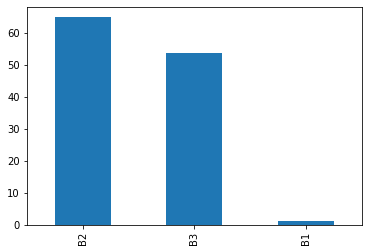

In [23]:
import matplotlib.pyplot as plt

output_df['Form_type'].value_counts().plot.bar()
plt.show()

In [24]:
output_df['Form_type'].value_counts()

B2    65
B3    54
B1     1
Name: Form_type, dtype: int64